# <center> Предсказание победителя в Dota 2

<https://meduza.io/feature/2021/10/19/rossiyskaya-komanda-vyigrala-chempionat-mira-po-dota-2-i-poluchila-18-millionov-dollarov-postoyte-otkuda-takie-dengi-neuzheli-igrat-v-dotu-tak-slozhno>

The general idea of the game: players destroy creeps, neutral creatures, and enemy heroes.

 - players earn gold => buy new gear from shops
 - gain experience => open levels and gain or improve new abilities all this makes them stronger, helps to destroy enemy defenses and destroy the throne.

Some explanations <https://www.kaggle.com/c/mlcourse-dota2-win-prediction/discussion/108067>

# Content
1. EDA
2. Some models and original dataset
3. Same models and team-wise dataset
4. Ensembles
5. Same models and team-wise-diff dataset
6. Feature importance
7. RandomForest hyperparameters
8. team-wise mean+std [Draft]
9. KDA [Draft]
10. How about new features from raw data? [Draft]
11. CAT hyperparameters [Draft]
12. Boruta for feature selection [Draft]


## Reflection
It's common to have reflection at the end, to look back. But I'd like thinking over further plans and improvements (and who will scroll to the very end of this long canvas...).

Datasets:
1. Experiments with different datasets showed that team-wise diff+std is a good direction of work (for decision trees for sure). So hyper parameters tuning and feature importance should be done with regard to that dataset.
2. New features:
    - I've added four new features
    - it's interesting to add time-series variables (e.g. gold over time, or xp over time)
    - intuitively KDA is a good feature, especially as a replacement of kills-deaths-assists. but requires some investigation, wasn't a simple step
    - I still have idea to check variables in form of _gold/time_remaining_
3. conduct sensitivity analysis

Models:
1. it seems playing with 3 estimators (CAT, RF, LR) is quite enough. so we should do hyperparams tuning for all of them.
2. The same for feature selection based on Boruta
3. Ensembles - a blind spot in fact.


__Let this fun to begin! ;)__

In [1]:
import os
import json
import pandas as pd
import datetime
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score
import time
from boruta import BorutaPy
from sklearn.model_selection import GridSearchCV

%matplotlib inline

In [2]:
SEED = 10801
sns.set_style(style="whitegrid")
plt.rcParams["figure.figsize"] = 12, 8
warnings.filterwarnings("ignore")

## <left>Data Description

Files:

- `sample_submission.csv`: пример файла-посылки submission file example 
- `train_raw_data.jsonl`, `test_raw_data.jsonl`: raw data 
- `train_data.csv`, `test_data.csv`: features from the author
- `train_targets.csv`: the results of the training games

## <left>Description of features
    
A set of simple features that describe players and teams

In [3]:
PATH_TO_DATA = "./input/bi-2021-ml-competitions-dota2"

df_train_features = pd.read_csv(os.path.join(PATH_TO_DATA,
                                             "train_data.csv"),
                                    index_col="match_id_hash")
df_train_targets = pd.read_csv(os.path.join(PATH_TO_DATA,
                                            "train_targets.csv"),
                                   index_col="match_id_hash")

## 1. EDA

Let's check if classes of target variable is balanced:

In [4]:
df_train_targets.radiant_win.value_counts()

True     16670
False    15028
Name: radiant_win, dtype: int64

We can say that classes are __balanced__

In [5]:
df_train_features.shape

(31698, 245)

In [6]:
df_train_features.head()

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,d5_stuns,d5_creeps_stacked,d5_camps_stacked,d5_rune_pickups,d5_firstblood_claimed,d5_teamfight_participation,d5_towers_killed,d5_roshans_killed,d5_obs_placed,d5_sen_placed
match_id_hash,,,,,,,,,,,,,,,,,,,,,
b9c57c450ce74a2af79c9ce96fac144d,658,4,0,3,10,15,7,2,0,7,...,0.000000,0,0,0,0,0.00,0,0,0,0
6db558535151ea18ca70a6892197db41,21,23,0,0,0,101,0,0,0,0,...,0.000000,0,0,0,0,0.00,0,0,0,0
19c39fe2af2b547e48708ca005c6ae74,160,22,7,0,0,57,0,0,0,1,...,0.000000,0,0,0,0,0.00,0,0,0,0
c96d629dc0c39f0c616d1949938a6ba6,1016,22,0,1,0,119,0,3,3,5,...,8.264696,0,0,3,0,0.25,0,0,3,0
156c88bff4e9c4668b0f53df3d870f1b,582,22,7,2,2,12,3,1,2,9,...,15.762911,3,1,0,1,0.50,0,0,3,0


Имеем ~32 тысячи наблюдений, каждое из которых характеризуется уникальным `match_id_hash` (захэшированное id матча), и 245 признаков. `game_time` показывает момент времени, в который получены эти данные. То есть по сути это не длительность самого матча, а например, его середина, таким образом, в итоге мы сможем получить модель, которая будет предсказывать вероятность победы каждой из команд в течение матча (хорошо подходит для букмекеров).

Lets have a look what kind of features we have in base dataset:

In [7]:
df_train_features.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 31698 entries, b9c57c450ce74a2af79c9ce96fac144d to e2ca68ac1a6847f4a37f6c9c8ee8695b
Data columns (total 245 columns):
 #    Column                      Dtype  
---   ------                      -----  
 0    game_time                   int64  
 1    game_mode                   int64  
 2    lobby_type                  int64  
 3    objectives_len              int64  
 4    chat_len                    int64  
 5    r1_hero_id                  int64  
 6    r1_kills                    int64  
 7    r1_deaths                   int64  
 8    r1_assists                  int64  
 9    r1_denies                   int64  
 10   r1_gold                     int64  
 11   r1_lh                       int64  
 12   r1_xp                       int64  
 13   r1_health                   int64  
 14   r1_max_health               int64  
 15   r1_max_mana                 float64
 16   r1_level                    int64  
 17   r1_x                        int64

In [8]:
list(df_train_features.columns.values)

['game_time',
 'game_mode',
 'lobby_type',
 'objectives_len',
 'chat_len',
 'r1_hero_id',
 'r1_kills',
 'r1_deaths',
 'r1_assists',
 'r1_denies',
 'r1_gold',
 'r1_lh',
 'r1_xp',
 'r1_health',
 'r1_max_health',
 'r1_max_mana',
 'r1_level',
 'r1_x',
 'r1_y',
 'r1_stuns',
 'r1_creeps_stacked',
 'r1_camps_stacked',
 'r1_rune_pickups',
 'r1_firstblood_claimed',
 'r1_teamfight_participation',
 'r1_towers_killed',
 'r1_roshans_killed',
 'r1_obs_placed',
 'r1_sen_placed',
 'r2_hero_id',
 'r2_kills',
 'r2_deaths',
 'r2_assists',
 'r2_denies',
 'r2_gold',
 'r2_lh',
 'r2_xp',
 'r2_health',
 'r2_max_health',
 'r2_max_mana',
 'r2_level',
 'r2_x',
 'r2_y',
 'r2_stuns',
 'r2_creeps_stacked',
 'r2_camps_stacked',
 'r2_rune_pickups',
 'r2_firstblood_claimed',
 'r2_teamfight_participation',
 'r2_towers_killed',
 'r2_roshans_killed',
 'r2_obs_placed',
 'r2_sen_placed',
 'r3_hero_id',
 'r3_kills',
 'r3_deaths',
 'r3_assists',
 'r3_denies',
 'r3_gold',
 'r3_lh',
 'r3_xp',
 'r3_health',
 'r3_max_health',
 '

We have:

r1, ..., r5 - a prefix of Radiant team player
d1, ..., d5 - a prefix of Dire team player


each team player has:
1. hero_id
2. kills
3. deaths
4. assists
5. denies
6. gold
7. lh
8. xp
9. health
10. max_health
11. max_mana
12. level
13. x
14. y
15. stuns
16. creeps_stacked
17. camps_stacked
18. rune_pickups
19. firstblood_claimed
20. teamfight_participation
21. towers_killed
22. roshans_killed
23. obs_placed
24. sen_placed

this gives 240 variables for 10 players
and we have first 5 columns:
1. game_time
2. game_mode
3. lobby_type
4. objectives_len
5. chat_len

Variables are either float64 or int64, however _hero_id_ is categorical variable in fact, it's a number of hero.

__TODO__ For _hero_ we need apply encoding, but i simply omit it from consideration.



Variables _game_time, game_mode, lobby_type, objectives_len, chat_len_ seem to be technical one and not important for predicition. Lets explore them closely:

#### game_time

game_time is a moment of time when data was collected. The goal of this task is to predict a winner, so we may omit it. We might need it for feature engineering and adding more features we'd need _game_time_ to combine features.

__TODO__ We can use _time_remaining_ from raw dataset, and add a feature _team_gold_diff/time_remaining_:
which means that the bigger difference of gold between teams and the less time remains, the higher chances a team wins/loses. This way we amplify exising features Maybe it worth applying this approach to _important_ features, not all of them.



<AxesSubplot:>

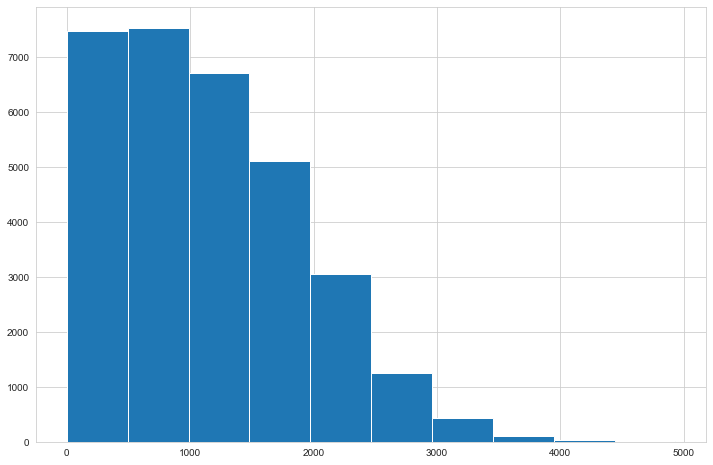

In [9]:
df_train_features.game_time.hist()

#### lobby_type

In [10]:
df_train_features.lobby_type.value_counts()

7    21607
0    10091
Name: lobby_type, dtype: int64

<AxesSubplot:xlabel='lobby_type', ylabel='Count'>

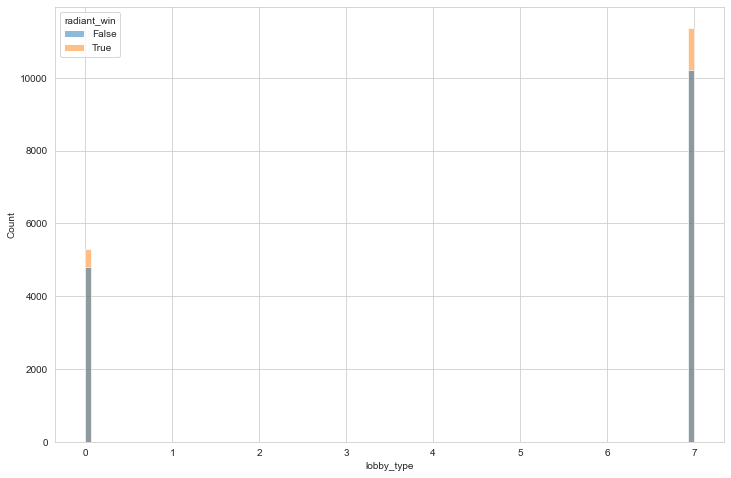

In [11]:
sns.histplot(data=pd.concat([df_train_features.lobby_type, df_train_targets.radiant_win], axis=1), x="lobby_type", hue="radiant_win", bins=100)

So _lobby_type_ has two values and they don't determine a winner, as the histogram above shows.

__TODO__ I think i was a bit overconfident about it: having lobby_type=7 we may say Radiants has a fraction of chance higher to win. Anyway, it's better proving it via experiment.

#### game_mode

Quite the same as _lobby_type_:


In [12]:
df_train_features.game_mode.value_counts()

22    25324
4      2877
23     2079
3       948
2       315
5       148
12        5
16        2
Name: game_mode, dtype: int64

<AxesSubplot:xlabel='game_mode', ylabel='Count'>

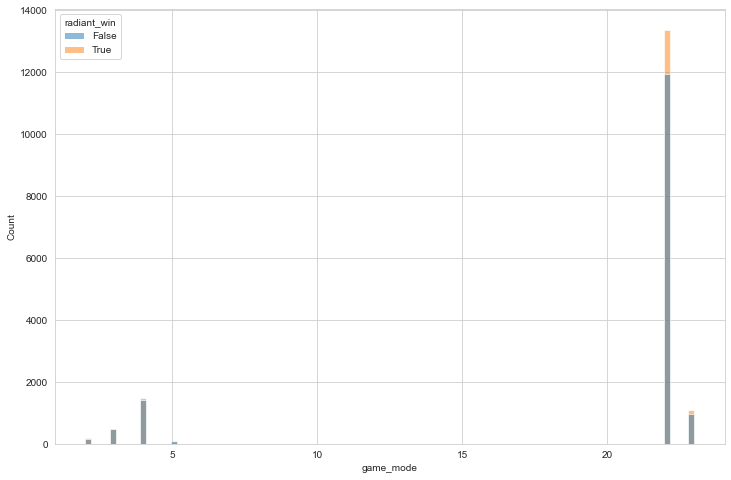

In [13]:
sns.histplot(data=pd.concat([df_train_features.game_mode, df_train_targets.radiant_win], axis=1), x="game_mode", hue="radiant_win", bins=100)

#### objectives_len & chat_len

These two variables are lenghts of arrays which we have in raw dataset, in *.jsonl.
They are technical, we definitely omit them.


### Missing values

fortunately we dont have them in _df_train_features_

In [14]:
df_train_features.isnull().sum().sum()

0

In [15]:
X = df_train_features
y = df_train_targets["radiant_win"]
cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=SEED)

## 2. Some models and original dataset

### Feature selection

Initial train dataset has 245 features, we will omit 5 of them (mentioned above). The rest are about each player statistics: gold, xp, KDA and etc.
We already have a baseline solution:
RF: accuracy=0.689 mean roc_auc_score=0.775

We also know that adding _radiant_tower_kills, dire_tower_kills, diff_tower_kills_ features increased roc_auc_score up to 0.778796.

Then it's natural to assume that we need team statistics instead of 10 players statistics. The reason behind this: having one high-performant player is not enough to win, entire team should be good enough and balanced.
Besides, aggregating players statistics significantly decreases amount of features:
instead of having 10 features (r1, ..., r5, d1, ..., d5) for _gold_ we can have just two: _r_gold, d_gold_, so 5 times less.
Less feature -> faster model & avoiding overfitting.

Well, we cannot be sure about this assumption, so we will check:
we try different models with original dataset and reduced one, to see performances of different models both in terms of accuracy & roc_auc_score  and how fast they are.


In [16]:
import xgboost
import lightgbm
import catboost
from sklearn.ensemble import (RandomForestClassifier,
                              ExtraTreesClassifier,
                              VotingClassifier)
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

from sklearn.preprocessing import StandardScaler

In [17]:
# this function helps us to try different models with different datasets
def try_model(X, y, name, model):
    start = time.time()

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_train, X_valid, y_train, y_valid = train_test_split(X_scaled, y,
                                                      test_size=0.3,
                                                      random_state=SEED)

    cv_scores = cross_val_score(model, X_scaled, y, cv=cv, scoring="roc_auc")

    model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_valid)[:, 1]
    accuracy = accuracy_score(y_valid, y_pred > 0.5)
    print(f"{name:>10}: accuracy={accuracy:.3f} mean roc_auc_score={cv_scores.mean():.6f} {time.time() - start:.0f} sec")
    return name, accuracy, cv_scores.mean()

In [18]:
dt = DecisionTreeClassifier(random_state=SEED, max_depth=10, min_samples_leaf=10)
rf = RandomForestClassifier(n_estimators=300, max_depth=7, random_state=SEED)
etc = ExtraTreesClassifier(random_state=SEED)
knn = KNeighborsClassifier(n_neighbors=5, weights="distance")
svc_lin = SVC(kernel='linear', probability=True, random_state=SEED)
svc_rbf = SVC(kernel='rbf', probability=True, random_state=SEED)
cat = catboost.CatBoostClassifier(verbose=False, random_seed=SEED)
lgbm = lightgbm.LGBMClassifier(random_state=SEED, silent=True, verbosity=-1)
lgbm_rf = lightgbm.LGBMClassifier(boosting_type="rf", bagging_freq=1, bagging_fraction=0.7, random_state=SEED, silent=True, verbosity=-1)
xgboost.set_config(verbosity=0)
xgb = xgboost.XGBClassifier(random_state=SEED)
xgb_rf = xgboost.XGBRFClassifier(random_state=SEED)
lr = LogisticRegression(solver='liblinear', max_iter=10000)
nb = GaussianNB()

base_models = [
    ("DT", dt),
    ("RF", rf),
    ("ETC", etc),
    ("KNN", knn),
    # ("SVC_LIN", svc_lin),  # significantly time consuming, ~10mins is too much waiting for one model
    # ("SVC_RBF", svc_rbf),  # significantly time consuming
    ("CAT", cat), 
    ("LGBM", lgbm),
    ("LGBM_RF", lgbm_rf),
    ("XGB", xgb),
    ("XGB_RF", xgb_rf),
    ("LR", lr),
    ("NB", nb)
]

__Running our models ...__


In [19]:
%%time
for name, model in base_models:
    try_model(X, y, name, model)

__Outcome:__
Just simple iteration over default models gives us several good results, which are better than RF baseline:

LR: accuracy=0.720 mean roc_auc_score=0.806892
CAT: accuracy=0.709 mean roc_auc_score=0.799254
LGBM: accuracy=0.708 mean roc_auc_score=0.792507
ETC: accuracy=0.698 mean roc_auc_score=0.775045
XGB: accuracy=0.694 mean roc_auc_score=0.777831
RF: accuracy=0.689 mean roc_auc_score=0.772022

It took 18 min to calculate them.

## 3. Same models and team-wise dataset

Now lets try to build reduced dataset:

_dfa_ - is original dataset subtracted _game_time, game_mode, lobby_type and lens_.

In [20]:
dfa = df_train_features.drop(["game_time", "game_mode", "lobby_type", "objectives_len", "chat_len"], axis=1)

Below i construct reduced dataset by summing up variables as following:
kill
deaths
assists
denies
gold
lh
xp
health
stuns
creeps_stacked
camps_stacked
rune_pickups
firstblood_claimed
teamfight_participation
towers_killed
roshans_killed
obs_placed
sen_placed

__NOTE__: I've excluded variables _max_health, max_mana, level, x, y_. Well, it's resonable to exlcude _x, y_, for the reset i'm not that sure at the end of the day.

In result we have two sets of these variables for team Radiant and team Dire.
Run the same models and compare results with original dataset:



In [21]:
reduced_df = pd.concat(
    [
        (sum([dfa.iloc[:, 1 + i*24] for i in range(0, 5)])).rename("r_kills"),
        (sum([dfa.iloc[:, 1 + i*24] for i in range(5, 9)])).rename("d_kills"),

        (sum([dfa.iloc[:, 2 + i*24] for i in range(0, 5)])).rename("r_deaths"),
        (sum([dfa.iloc[:, 2 + i*24] for i in range(5, 9)])).rename("d_deaths"),

        (sum([dfa.iloc[:, 3 + i*24] for i in range(0, 5)])).rename("r_assists"),
        (sum([dfa.iloc[:, 3 + i*24] for i in range(5, 9)])).rename("d_assists"),

        (sum([dfa.iloc[:, 4 + i*24] for i in range(0, 5)])).rename("r_denies"),
        (sum([dfa.iloc[:, 4 + i*24] for i in range(5, 9)])).rename("d_denies"),

        (sum([dfa.iloc[:, 5 + i*24] for i in range(0, 5)])).rename("r_gold"),
        (sum([dfa.iloc[:, 5 + i*24] for i in range(5, 9)])).rename("d_gold"),

        (sum([dfa.iloc[:, 6 + i*24] for i in range(0, 5)])).rename("r_lh"),
        (sum([dfa.iloc[:, 6 + i*24] for i in range(5, 9)])).rename("d_lh"),

        (sum([dfa.iloc[:, 7 + i*24] for i in range(0, 5)])).rename("r_xp"),
        (sum([dfa.iloc[:, 7 + i*24] for i in range(5, 9)])).rename("d_xp"),

        (sum([dfa.iloc[:, 8 + i*24] for i in range(0, 5)])).rename("r_health"),
        (sum([dfa.iloc[:, 8 + i*24] for i in range(5, 9)])).rename("d_health"),

        (sum([dfa.iloc[:, 14 + i*24] for i in range(0, 5)])).rename("r_stuns"),
        (sum([dfa.iloc[:, 14 + i*24] for i in range(5, 9)])).rename("d_stuns"),

        (sum([dfa.iloc[:, 15 + i*24] for i in range(0, 5)])).rename("r_creeps_stacked"),
        (sum([dfa.iloc[:, 15 + i*24] for i in range(5, 9)])).rename("d_creeps_stacked"),

        (sum([dfa.iloc[:, 16 + i*24] for i in range(0, 5)])).rename("r_camps_stacked"),
        (sum([dfa.iloc[:, 16 + i*24] for i in range(5, 9)])).rename("d_camps_stacked"),

        (sum([dfa.iloc[:, 17 + i*24] for i in range(0, 5)])).rename("r_rune_pickups"),
        (sum([dfa.iloc[:, 17 + i*24] for i in range(5, 9)])).rename("d_rune_pickups"),

        (sum([dfa.iloc[:, 20 + i*24] for i in range(0, 5)])).rename("r_towers_killed"),
        (sum([dfa.iloc[:, 20 + i*24] for i in range(5, 9)])).rename("d_towers_killed"),

        (sum([dfa.iloc[:, 21 + i*24] for i in range(0, 5)])).rename("r_roshans_killed"),
        (sum([dfa.iloc[:, 21 + i*24] for i in range(5, 9)])).rename("d_roshans_killed"),

        (sum([dfa.iloc[:, 22 + i*24] for i in range(0, 5)])).rename("r_obs_placed"),
        (sum([dfa.iloc[:, 22 + i*24] for i in range(5, 9)])).rename("d_obs_placed"),

        (sum([dfa.iloc[:, 23 + i*24] for i in range(0, 5)])).rename("r_sen_placed"),
        (sum([dfa.iloc[:, 23 + i*24] for i in range(5, 9)])).rename("d_sen_placed"),

    ],
    axis=1)

In [22]:
reduced_df

,r_kills,d_kills,r_deaths,d_deaths,r_assists,d_assists,r_denies,d_denies,r_gold,d_gold,...,r_rune_pickups,d_rune_pickups,r_towers_killed,d_towers_killed,r_roshans_killed,d_roshans_killed,r_obs_placed,d_obs_placed,r_sen_placed,d_sen_placed
match_id_hash,,,,,,,,,,,,,,,,,,,,,
b9c57c450ce74a2af79c9ce96fac144d,16,3,4,14,14,3,28,15,18172,11721,...,13,14,1,0,0,0,4,5,3,2
6db558535151ea18ca70a6892197db41,0,0,0,0,0,0,0,0,880,384,...,3,1,0,0,0,0,0,0,0,0
19c39fe2af2b547e48708ca005c6ae74,0,0,0,0,0,0,9,5,2947,1426,...,7,0,0,0,0,0,1,0,0,0
c96d629dc0c39f0c616d1949938a6ba6,9,11,12,9,12,10,33,30,23650,18058,...,32,9,0,0,0,0,6,4,2,1
156c88bff4e9c4668b0f53df3d870f1b,6,8,10,4,7,7,37,44,12628,11711,...,9,12,0,1,0,0,2,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
b794aa55646841a03c7783226e6f6bc8,31,35,41,30,59,73,40,24,85043,80278,...,36,40,2,7,0,0,7,17,0,5
308faee28efee2e66b39f9f2ba6ea9cf,26,18,19,21,37,10,51,52,85925,66124,...,59,35,1,3,1,1,15,2,19,14
6066cc7417b43c749d551e123d00f0c8,6,14,18,6,11,21,7,8,21706,18591,...,12,13,1,0,0,0,1,2,0,0


In [23]:
%%time
print("reduced_df")
for name, model in base_models:
    try_model(reduced_df, y, name, model)

What we obtained?

4min instead of 17 min, that's a great result, we can experiment with models quicker!

For RandomForest: we got accuracy=0.697 mean roc_auc_score=0.779215
so it's better than RF with original dataset and the idea to aggregate dataset was right.

CAT and LR are quite the same and still at top:

LR: accuracy=0.720 mean roc_auc_score=0.801472
CAT: accuracy=0.711 mean roc_auc_score=0.796126
LGBM: accuracy=0.707 mean roc_auc_score=0.791814
ETC: accuracy=0.700 mean roc_auc_score=0.780517
XGB: accuracy=0.695 mean roc_auc_score=0.779598
RF: accuracy=0.697 mean roc_auc_score=0.779215
LGBM_RF: accuracy=0.682 mean roc_auc_score=0.753439

__NOTE__ it's better having _gold_diff_ in dataset rather than _r_gold_ and _d_gold_, because
it has more meaning: if it's negative, then radiant has less gold, then it has lower chances to win, so decision trees can use such variable to split ndoes, it's natural.
Below i created another dataset of diff values, and also included _max_health, max_mana, level_ variables.

## 4. Ensembles

We can try different combinations of models (all pairs and all triples)

In [24]:
from itertools import combinations
from tqdm.notebook import tqdm

_models = list(combinations([
    ("CAT", cat),
    ("LGBM", lgbm),
    ("LGBM_RF", lgbm_rf),
    ("XGB", xgb),
    ("XGB_RF", xgb_rf),
    ("LR", lr),
    ("NB", nb),
    ("RF", rf)], 2))

results = []
for e1, e2 in tqdm(_models, total=len(_models)):
# for e1, e2 in _models:
    voting = VotingClassifier(voting="soft", estimators=[e1, e2])
    name, acc_score, cv_score = try_model(reduced_df, y, "soft_voting", voting)
    results.append((cv_score, acc_score, e1[0], e2[0]))

results.sort(key=lambda i: i[0], reverse=True)

for cv_score, acc_score, e1, e2 in results:
    print(f"roc_auc_score={cv_score:.3f} =accuracy{acc_score:.3f} {e1} + {e2}")

  0%|          | 0/28 [00:00<?, ?it/s]

soft_voting: accuracy=0.710 mean roc_auc_score=0.795940 54 sec
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
soft_voting: accuracy=0.691 mean roc_auc_score=0.769415 43 sec
soft_voting: accuracy=0.699 mean roc_

Top 3 ensembles:
 CAT+LR roc_auc_score=0.803 =accuracy0.714
LGBM+LR roc_auc_score=0.802 =accuracy0.716
  RF+LR roc_auc_score=0.800 =accuracy0.715

Frankly saying, it's not better than CAR or LR alone.


In [25]:
_models = list(combinations([
    ("CAT", cat),
    ("LGBM", lgbm),
    ("LGBM_RF", lgbm_rf),
    ("XGB", xgb),
    ("XGB_RF", xgb_rf),
    ("LR", lr),
    ("NB", nb),
    ("RF", rf)], 3))

results = []
for e1, e2, e3 in tqdm(_models, total=len(_models)):
# for e1, e2, e3 in _models:
    voting = VotingClassifier(voting="soft", estimators=[e1, e2, e3])
    name, acc_score, cv_score = try_model(reduced_df, y, "soft_voting", voting)
    results.append((cv_score, acc_score, e1[0], e2[0], e3[0]))

results.sort(key=lambda i: i[0], reverse=True)

for cv_score, acc_score, e1, e2, e3 in results:
    print(f"roc_auc_score={cv_score:.3f} =accuracy{acc_score:.3f} {e1} + {e2} + {e3}")

  0%|          | 0/56 [00:00<?, ?it/s]

soft_voting: accuracy=0.707 mean roc_auc_score=0.792139 42 sec
soft_voting: accuracy=0.709 mean roc_auc_score=0.794038 52 sec
soft_voting: accuracy=0.706 mean roc_auc_score=0.793128 54 sec
soft_voting: accuracy=0.712 mean roc_auc_score=0.801580 47 sec
soft_voting: accuracy=0.704 mean roc_auc_score=0.785207 47 sec
soft_voting: accuracy=0.709 mean roc_auc_score=0.794959 84 sec
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_f

soft_voting: accuracy=0.711 mean roc_auc_score=0.797016 5 sec
soft_voting: accuracy=0.693 mean roc_auc_score=0.775405 4 sec
soft_voting: accuracy=0.702 mean roc_auc_score=0.784992 48 sec
soft_voting: accuracy=0.705 mean roc_auc_score=0.789374 18 sec
soft_voting: accuracy=0.714 mean roc_auc_score=0.798284 12 sec
soft_voting: accuracy=0.705 mean roc_auc_score=0.782534 11 sec
soft_voting: accuracy=0.709 mean roc_auc_score=0.791269 56 sec
soft_voting: accuracy=0.712 mean roc_auc_score=0.797844 10 sec
soft_voting: accuracy=0.691 mean roc_auc_score=0.776551 9 sec
soft_voting: accuracy=0.704 mean roc_auc_score=0.786313 52 sec
soft_voting: accuracy=0.702 mean roc_auc_score=0.788423 3 sec
soft_voting: accuracy=0.714 mean roc_auc_score=0.799618 45 sec
soft_voting: accuracy=0.694 mean roc_auc_score=0.777837 44 sec
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
soft_voting: accuracy=0.678 mean roc_auc_score=0.759791 10 sec
[LightGBM] [Warning] bagging_fraction

TOP 3:
roc_auc_score=0.802 =accuracy0.712 CAT + LGBM + LR
roc_auc_score=0.801 =accuracy0.717 CAT + LR + RF
roc_auc_score=0.800 =accuracy0.713 CAT + XGB_RF + LR

Also not impressive.
__TODO__: what can be improved?
1. models are not tuned, i mean hyperparams.
2. reduced dataset is not best one, better to use dataset of diffs and std-s (see below)

## 5. Same models and team-wise-diff dataset

Here is an attempt to try differences between Radiant and Dire teams for each variable.
This should be a better feature, because for decision-tree-family algorithms it's more natural way to split nodes.


In [26]:
reduced_df2 = pd.concat(
    [
        (sum([dfa.iloc[:, 1 + i*24] for i in range(0, 5)]) -
         sum([dfa.iloc[:, 1 + i*24] for i in range(5, 9)])).rename("kills"),

        (sum([dfa.iloc[:, 2 + i*24] for i in range(0, 5)]) -
         sum([dfa.iloc[:, 2 + i*24] for i in range(5, 9)])).rename("deaths"),

        (sum([dfa.iloc[:, 3 + i*24] for i in range(0, 5)]) -
         sum([dfa.iloc[:, 3 + i*24] for i in range(5, 9)])).rename("assists"),

        (sum([dfa.iloc[:, 4 + i*24] for i in range(0, 5)]) -
         sum([dfa.iloc[:, 4 + i*24] for i in range(5, 9)])).rename("denies"),

        (sum([dfa.iloc[:, 5 + i*24] for i in range(0, 5)]) -
         sum([dfa.iloc[:, 5 + i*24] for i in range(5, 9)])).rename("gold"),

        (sum([dfa.iloc[:, 6 + i*24] for i in range(0, 5)]) -
         sum([dfa.iloc[:, 6 + i*24] for i in range(5, 9)])).rename("lh"),

        (sum([dfa.iloc[:, 7 + i*24] for i in range(0, 5)]) -
         sum([dfa.iloc[:, 7 + i*24] for i in range(5, 9)])).rename("xp"),

        (sum([dfa.iloc[:, 8 + i*24] for i in range(0, 5)]) -
         sum([dfa.iloc[:, 8 + i*24] for i in range(5, 9)])).rename("health"),

        (sum([dfa.iloc[:, 14 + i*24] for i in range(0, 5)]) -
         sum([dfa.iloc[:, 14 + i*24] for i in range(5, 9)])).rename("stuns"),

        (sum([dfa.iloc[:, 15 + i*24] for i in range(0, 5)]) -
         sum([dfa.iloc[:, 15 + i*24] for i in range(5, 9)])).rename("creeps_stacked"),

        (sum([dfa.iloc[:, 16 + i*24] for i in range(0, 5)]) -
         sum([dfa.iloc[:, 16 + i*24] for i in range(5, 9)])).rename("camps_stacked"),

        (sum([dfa.iloc[:, 17 + i*24] for i in range(0, 5)]) -
         sum([dfa.iloc[:, 17 + i*24] for i in range(5, 9)])).rename("rune_pickups"),

        (sum([dfa.iloc[:, 20 + i*24] for i in range(0, 5)]) -
         sum([dfa.iloc[:, 20 + i*24] for i in range(5, 9)])).rename("towers_killed"),

        (sum([dfa.iloc[:, 21 + i*24] for i in range(0, 5)]) -
         sum([dfa.iloc[:, 21 + i*24] for i in range(5, 9)])).rename("roshans_killed"),

        (sum([dfa.iloc[:, 22 + i*24] for i in range(0, 5)]) -
         sum([dfa.iloc[:, 22 + i*24] for i in range(5, 9)])).rename("obs_placed"),

        (sum([dfa.iloc[:, 23 + i*24] for i in range(0, 5)]) -
         sum([dfa.iloc[:, 23 + i*24] for i in range(5, 9)])).rename("sen_placed"),

    ],
    axis=1)

In [27]:
%%time
print("reduced_df2")
for name, model in base_models:
    try_model(reduced_df2, y, name, model)

reduced_df2
        DT: accuracy=0.671 mean roc_auc_score=0.747803 1 sec
        RF: accuracy=0.705 mean roc_auc_score=0.789811 33 sec
       ETC: accuracy=0.705 mean roc_auc_score=0.784708 14 sec
       KNN: accuracy=0.666 mean roc_auc_score=0.730571 17 sec
       CAT: accuracy=0.707 mean roc_auc_score=0.792687 33 sec
      LGBM: accuracy=0.707 mean roc_auc_score=0.791584 1 sec
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsamp

Comparing with "3.-same-models-and-team-wise-dataset"
 - LR shows worse performance, 0.801 vs 0.786
 - CAT shows slightly worse performance: 0.796 vs 0.792
 - RF shows up better: 0.779 vs 0.790.

So for decision trees we did a good move by using diff variables, but for LogRegression it didn't, it seems we lost some important picies of information.


One of good side of team-diff variables, we can plot a heatmap of correlation

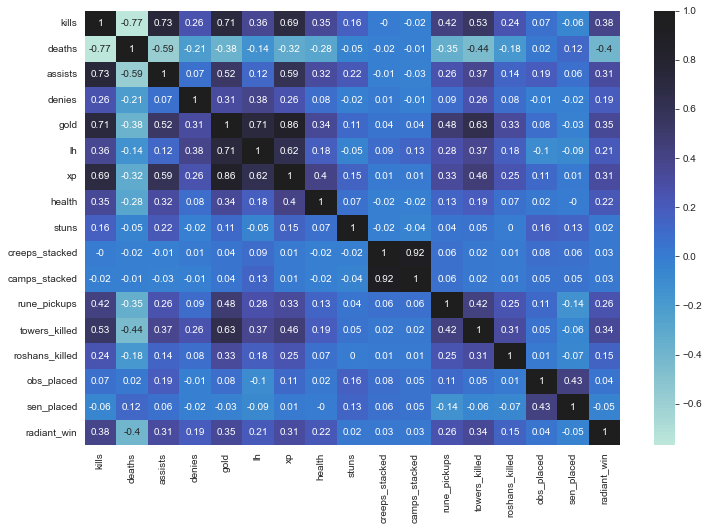

In [28]:
sns.heatmap(data=pd.concat([reduced_df2, y], axis=1).corr().round(2), annot=True, center=1);

We see high correlation between
- _kills, assists and deaths_
- _gold, xp and lh_
- _gold_ and _kills, assists_
- _creeps_stacked and camps_stacked_

__TODO__ Ideally it is worth to do sensitivity analysis <https://towardsdatascience.com/the-sensitivity-analysis-a-powerful-yet-underused-tool-for-data-scientists-e553fa695976>
Below i will discover that this dataset isnt the best: we can use diff and std as features and add another features from raw dataset. So it's better to repeat correlation analysis for it.
Here we just crasp a general idea.


Below is a weak attempt to remove lowest-correlation variables from the previous dataset and try it on our models.

those variables are: stuns, creeps_stacked, camps_stacked, obs_placed, sen_placed.

In [29]:
reduced_df3 = pd.concat(
    [
        (sum([dfa.iloc[:, 1 + i*24] for i in range(0, 5)]) -
         sum([dfa.iloc[:, 1 + i*24] for i in range(5, 9)])).rename("kills"),

        (sum([dfa.iloc[:, 2 + i*24] for i in range(0, 5)]) -
         sum([dfa.iloc[:, 2 + i*24] for i in range(5, 9)])).rename("deaths"),

        (sum([dfa.iloc[:, 3 + i*24] for i in range(0, 5)]) -
         sum([dfa.iloc[:, 3 + i*24] for i in range(5, 9)])).rename("assists"),

        (sum([dfa.iloc[:, 4 + i*24] for i in range(0, 5)]) -
         sum([dfa.iloc[:, 4 + i*24] for i in range(5, 9)])).rename("denies"),

        (sum([dfa.iloc[:, 5 + i*24] for i in range(0, 5)]) -
         sum([dfa.iloc[:, 5 + i*24] for i in range(5, 9)])).rename("gold"),

        (sum([dfa.iloc[:, 6 + i*24] for i in range(0, 5)]) -
         sum([dfa.iloc[:, 6 + i*24] for i in range(5, 9)])).rename("lh"),

        (sum([dfa.iloc[:, 7 + i*24] for i in range(0, 5)]) -
         sum([dfa.iloc[:, 7 + i*24] for i in range(5, 9)])).rename("xp"),

        (sum([dfa.iloc[:, 8 + i*24] for i in range(0, 5)]) -
         sum([dfa.iloc[:, 8 + i*24] for i in range(5, 9)])).rename("health"),

        # (sum([dfa.iloc[:, 14 + i*24] for i in range(0, 5)]) -
        #  sum([dfa.iloc[:, 14 + i*24] for i in range(5, 9)])).rename("stuns"),
        #
        # (sum([dfa.iloc[:, 15 + i*24] for i in range(0, 5)]) -
        #  sum([dfa.iloc[:, 15 + i*24] for i in range(5, 9)])).rename("creeps_stacked"),
        #
        # (sum([dfa.iloc[:, 16 + i*24] for i in range(0, 5)]) -
        #  sum([dfa.iloc[:, 16 + i*24] for i in range(5, 9)])).rename("camps_stacked"),

        (sum([dfa.iloc[:, 17 + i*24] for i in range(0, 5)]) -
         sum([dfa.iloc[:, 17 + i*24] for i in range(5, 9)])).rename("rune_pickups"),

        (sum([dfa.iloc[:, 20 + i*24] for i in range(0, 5)]) -
         sum([dfa.iloc[:, 20 + i*24] for i in range(5, 9)])).rename("towers_killed"),

        (sum([dfa.iloc[:, 21 + i*24] for i in range(0, 5)]) -
         sum([dfa.iloc[:, 21 + i*24] for i in range(5, 9)])).rename("roshans_killed"),

        # (sum([dfa.iloc[:, 22 + i*24] for i in range(0, 5)]) -
        #  sum([dfa.iloc[:, 22 + i*24] for i in range(5, 9)])).rename("obs_placed"),
        #
        # (sum([dfa.iloc[:, 23 + i*24] for i in range(0, 5)]) -
        #  sum([dfa.iloc[:, 23 + i*24] for i in range(5, 9)])).rename("sen_placed"),

    ],
    axis=1)

In [30]:
%%time
print("reduced_df3")
for name, model in base_models:
    try_model(reduced_df3, y, name, model)

reduced_df3
        DT: accuracy=0.666 mean roc_auc_score=0.749512 1 sec
        RF: accuracy=0.705 mean roc_auc_score=0.789646 29 sec
       ETC: accuracy=0.703 mean roc_auc_score=0.781314 13 sec
       KNN: accuracy=0.674 mean roc_auc_score=0.729221 8 sec
       CAT: accuracy=0.706 mean roc_auc_score=0.792066 32 sec
      LGBM: accuracy=0.708 mean roc_auc_score=0.790797 1 sec
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsampl


Results are worse than for previous, so such a naive approch didnt work out :)
RF: accuracy=0.705 mean roc_auc_score=0.789646
CAT: accuracy=0.706 mean roc_auc_score=0.791975
LR: accuracy=0.707 mean roc_auc_score=0.785946



## 6. Feature importance


This is also a very draft attempt to look at feature importance.
So we have two datasets:
1. _reduced_df_ which has team-wise variables
2. _reduced_df2_ which as team-wise-diff variables

In [32]:
import eli5

In [33]:
_rf = RandomForestClassifier(n_estimators=100, n_jobs=4,
                                   max_depth=None, random_state=SEED)
_rf.fit(reduced_df, y)
eli5.show_weights(estimator=_rf, feature_names=list(reduced_df.columns))

Weight,Feature
0.0520 ± 0.0154,d_gold
0.0501 ± 0.0148,r_gold
0.0482 ± 0.0247,r_deaths
0.0464 ± 0.0145,d_xp
0.0460 ± 0.0088,d_health
0.0455 ± 0.0095,r_health
0.0447 ± 0.0124,r_xp
0.0443 ± 0.0258,r_kills
0.0388 ± 0.0088,r_lh
0.0381 ± 0.0092,d_lh


In [34]:
_rf = RandomForestClassifier(n_estimators=100, n_jobs=4,
                                   max_depth=None, random_state=SEED)
_rf.fit(reduced_df2, y)
eli5.show_weights(estimator=_rf, feature_names=list(reduced_df2.columns))

Weight,Feature
0.1259 ± 0.0646,gold
0.1016 ± 0.0820,deaths
0.0940 ± 0.0461,xp
0.0838 ± 0.0137,health
0.0727 ± 0.0751,kills
0.0724 ± 0.0208,lh
0.0723 ± 0.0080,stuns
0.0613 ± 0.0075,denies
0.0611 ± 0.0182,rune_pickups
0.0604 ± 0.0406,assists


For both datasets we can say top features are quite the same for RF.

In [35]:
_lr = LogisticRegression(solver='liblinear', max_iter=10000)
_lr.fit(reduced_df, y)
eli5.show_weights(estimator=_lr, feature_names=list(reduced_df.columns))

Weight?,Feature
+0.093,r_towers_killed
+0.092,d_kills
+0.067,r_kills
+0.018,r_obs_placed
+0.016,<BIAS>
+0.009,r_denies
+0.008,d_roshans_killed
+0.007,r_assists
+0.006,r_roshans_killed
+0.003,r_camps_stacked


In [36]:
_lr = LogisticRegression(solver='liblinear', max_iter=10000)
_lr.fit(reduced_df2, y)
eli5.show_weights(estimator=_lr, feature_names=list(reduced_df2.columns))

Weight?,Feature
+0.121,towers_killed
+0.018,obs_placed
+0.016,camps_stacked
+0.012,rune_pickups
+0.009,assists
+0.008,denies
+0.008,roshans_killed
+0.001,creeps_stacked
+0.000,health
+0.000,gold


## 7. RandomForest hyperparameters

Time to tuned RF a bit :) :tada:

In [37]:
from sklearn.model_selection import GridSearchCV

search = GridSearchCV(rf, {
    "n_estimators": [100, 200, 300],
    "min_samples_split": [5, 10, 50],
    "min_samples_leaf": [1, 2, 3, 5, 10]
}, scoring="roc_auc")

search.fit(reduced_df, y)
search.best_params_

{'min_samples_leaf': 5, 'min_samples_split': 50, 'n_estimators': 300}

In [38]:
%%time
for _df, name, model in [
    (reduced_df, "team-wise-df", RandomForestClassifier(n_estimators=300, n_jobs=4,min_samples_leaf=5, min_samples_split=50, random_state=SEED)),
    (reduced_df2, "team-wise-diff-df", RandomForestClassifier(n_estimators=300, n_jobs=4,min_samples_leaf=5, min_samples_split=50, random_state=SEED)),
]:
    try_model(_df, y, f"{name}_RF", model)

team-wise-df_RF: accuracy=0.705 mean roc_auc_score=0.790695 26 sec
team-wise-diff-df_RF: accuracy=0.708 mean roc_auc_score=0.793269 19 sec
CPU times: total: 32 s
Wall time: 44.5 s


For team-wise-diff-df (reduced_df2) RF showed 0.790, now it's 0.793.
So it's better.

## team-wise mean+std [Draft]

So far i worked with team-wise variables (sum of players stats) per each variable.
We can add standard deviation of each variable to capture how teams are balanced.
Below i create such dataset.
The idea came from <https://www.kaggle.com/code/artgor/dota-eda-fe-and-models/notebook>

In [39]:


variables_to_aggregate = [
    "kills", "deaths", "assists", "denies", "gold", "lh", "xp", "health", "max_health", "max_mana", "level",
"stuns", "creeps_stacked", "camps_stacked", "rune_pickups", "teamfight_participation", "towers_killed", "roshans_killed", "obs_placed", "sen_placed"
]

new_vars = []
for column in variables_to_aggregate:
    column_df = pd.concat([df_train_features[f"r{p}_{column}"] for p in "12345"], axis=1)
    new_vars.append(column_df.mean(axis=1).rename(f"r_{column}_mean"))
    new_vars.append(column_df.std(axis=1).rename(f"r_{column}_std"))

    column_df = pd.concat([df_train_features[f"d{p}_{column}"] for p in "12345"], axis=1)
    new_vars.append(column_df.mean(axis=1).rename(f"d_{column}_mean"))
    new_vars.append(column_df.std(axis=1).rename(f"d_{column}_std"))

new_df = pd.concat(new_vars, axis=1)


In [40]:
for name, model in [("RF", RandomForestClassifier(n_estimators=300, n_jobs=4,min_samples_leaf=5, min_samples_split=50, random_state=SEED)), ("LR", lr), ("CAT", cat)]:
    try_model(new_df, y, f"new_df_{name}", model)

 new_df_RF: accuracy=0.710 mean roc_auc_score=0.799065 37 sec
 new_df_LR: accuracy=0.726 mean roc_auc_score=0.813129 8 sec
new_df_CAT: accuracy=0.715 mean roc_auc_score=0.806569 70 sec


good, mean+std over good variabls demonstrated better performance!

We can try no dataset with team-wise variables but use differencies between original var.
I mean: initially we had _gold_ for each player, then we had mean(gold) and std(gold) for teams and
now let's have mean(r_gold) - mean(d_gold), std(r_gold), std(d_gold).

That approach will decrease amount of features, so at least we get faster algorithm, maybe even of better quality.

In [41]:
new_diff_vars = []
for column in variables_to_aggregate:
    column_r_df = pd.concat([df_train_features[f"r{p}_{column}"] for p in "12345"], axis=1)
    column_d_df = pd.concat([df_train_features[f"d{p}_{column}"] for p in "12345"], axis=1)

    new_diff_vars.append((column_r_df.sum(axis=1) - column_d_df.sum(axis=1)).rename(f"{column}_diff"))
    new_diff_vars.append(column_r_df.std(axis=1).rename(f"r_{column}_std"))
    new_diff_vars.append(column_d_df.std(axis=1).rename(f"d_{column}_std"))

new_diff_df = pd.concat(new_diff_vars, axis=1)


In [42]:
for name, model in [("RF", RandomForestClassifier(n_estimators=300, n_jobs=4,min_samples_leaf=5, min_samples_split=50, random_state=SEED)), ("LR", lr), ("CAT", cat)]:
    try_model(new_diff_df, y, f"diff_std_df_{name}", model)

diff_std_df_RF: accuracy=0.728 mean roc_auc_score=0.814993 40 sec
diff_std_df_LR: accuracy=0.726 mean roc_auc_score=0.813456 3 sec
diff_std_df_CAT: accuracy=0.727 mean roc_auc_score=0.816137 70 sec


LR gives quite the same results as for _new_df_ dataset, but RF is better: 0.799 vs 0.815.
CAT is much better: 0.806 vs 0.816!

## KDA [Draft]

Let try KDA. We have a hint about it from the task assignment itself.
i wonder if it will improve model quality.

In [43]:
# lets add KDA

def calculate_kda(df):
    r_player_kda = pd.concat([(df[f"r{p}_kills"] + df[f"r{p}_assists"]) / df[f"r{p}_deaths"].replace(0, 1) for p in "12345"] , axis=1)

    d_player_kda = pd.concat([(df[f"d{p}_kills"] + df[f"d{p}_assists"]) / df[f"d{p}_deaths"].replace(0, 1) for p in "12345"] , axis=1)

    return pd.concat([
    (r_player_kda.mean(axis=1) - d_player_kda.mean(axis=1)).rename("kda_diff"),
    r_player_kda.std(axis=1).rename("r_kda_std"),
    d_player_kda.std(axis=1).rename("d_kda_std")],
        axis=1)


In [44]:
new_diff_kda_df = pd.concat([new_diff_df, calculate_kda(df_train_features)], axis=1)

for name, model in [("RF", RandomForestClassifier(n_estimators=300, n_jobs=4,min_samples_leaf=5, min_samples_split=50, random_state=SEED)), ("LR", lr), ("CAT", cat)]:
    try_model(new_diff_kda_df, y, f"new_diff_kda_df_{name}", model)

new_diff_kda_df_RF: accuracy=0.726 mean roc_auc_score=0.814448 39 sec
new_diff_kda_df_LR: accuracy=0.725 mean roc_auc_score=0.814030 3 sec
new_diff_kda_df_CAT: accuracy=0.728 mean roc_auc_score=0.816011 80 sec


all three models show almost the same quality on dataset with KDA :)
maybe it's better to replace _kills, assists, deaths_ with KDA, but not complement them with KDA?
because KDA will greatly correlate with them.
lets check it:

In [45]:
only_kda_diff_std_df = new_diff_kda_df.drop(["kills_diff", "r_kills_std", "d_kills_std", "deaths_diff", "r_deaths_std", "d_deaths_std", "assists_diff", "r_assists_std", "d_assists_std"], axis=1)

for name, model in [("RF", RandomForestClassifier(n_estimators=300, n_jobs=4,min_samples_leaf=5, min_samples_split=50, random_state=SEED)), ("LR", lr), ("CAT", cat)]:
    try_model(only_kda_diff_std_df, y, f"only_kda_diff_std_df_{name}", model)

only_kda_diff_std_df_RF: accuracy=0.727 mean roc_auc_score=0.815730 41 sec
only_kda_diff_std_df_LR: accuracy=0.726 mean roc_auc_score=0.813594 3 sec
only_kda_diff_std_df_CAT: accuracy=0.725 mean roc_auc_score=0.815812 83 sec


OK, only KDA (no kills-assists-deaths) is better than KDA + kills-assists-deaths, but almost the same as only kills-assists-deaths.

## How about new features from raw data? [Draft]

we know that gold is important, but does a player use it?
we can count how many times a player did purchases, upagraded abilities, used items:

- items_uses
- ability_uses
- purchase_log
- ability_upgrades



In [46]:
try:
    import ujson as json
except ModuleNotFoundError:
    import json
    print ("Подумайте об установке ujson, чтобы работать с JSON объектами быстрее")

try:
    from tqdm.notebook import tqdm
except ModuleNotFoundError:
    tqdm_notebook = lambda x: x
    print ("Подумайте об установке tqdm, чтобы следить за прогрессом")


def read_matches(matches_file, total_matches=31698, n_matches_to_read=None):

    if n_matches_to_read is None:
        n_matches_to_read = total_matches

    c = 0
    with open(matches_file) as fin:
        for line in tqdm(fin, total=total_matches):
            if c >= n_matches_to_read:
                break
            else:
                c += 1
                yield json.loads(line)


Подумайте об установке ujson, чтобы работать с JSON объектами быстрее


In [47]:
def add_new_features(df_features, matches_file):

    vars = ["ability_upgrades", "purchase_log", "item_uses", "ability_uses"]

    for match in read_matches(matches_file):
        match_id_hash = match['match_id_hash']

        for var in vars:
            value = 0
            for player in match["players"][:5]:
                value += len(player[var])  # summing up all Radiant values

            for player in match["players"][5:]:
                value -= len(player[var])   #  subtracting all Dire valies
            df_features.loc[match_id_hash, f"{var}_diff"] = value


        # ... (/¯◡ ‿ ◡)/¯☆*:・ﾟ добавляем новые признаки ...

In [49]:
new_diff_ex_df = new_diff_df.copy()

add_new_features(new_diff_ex_df, os.path.join(PATH_TO_DATA, "train_raw_data.jsonl"))

  0%|          | 0/31698 [00:00<?, ?it/s]

In [50]:
for name, model in [("RF", RandomForestClassifier(n_estimators=300, n_jobs=4,min_samples_leaf=5, min_samples_split=50, random_state=SEED)), ("LR", lr), ("CAT", cat)]:
    try_model(new_diff_ex_df, y, f"new_diff_ex_df_{name}", model)

new_diff_ex_df_RF: accuracy=0.727 mean roc_auc_score=0.816076 48 sec
new_diff_ex_df_LR: accuracy=0.727 mean roc_auc_score=0.815047 4 sec
new_diff_ex_df_CAT: accuracy=0.728 mean roc_auc_score=0.818387 85 sec


Yayyy!  new features gave us better quality!
CAT 0.818, before we had .814 - 0.816


## CAT hyperparameters [Draft]

In [51]:
cat.get_all_params()

{'nan_mode': 'Min',
 'eval_metric': 'Logloss',
 'iterations': 1000,
 'sampling_frequency': 'PerTree',
 'leaf_estimation_method': 'Newton',
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'bayesian_matrix_reg': 0.10000000149011612,
 'force_unit_auto_pair_weights': False,
 'l2_leaf_reg': 3,
 'random_strength': 1,
 'rsm': 1,
 'boost_from_average': False,
 'model_size_reg': 0.5,
 'pool_metainfo_options': {'tags': {}},
 'subsample': 0.800000011920929,
 'use_best_model': False,
 'class_names': ['False', 'True'],
 'random_seed': 10801,
 'depth': 6,
 'posterior_sampling': False,
 'border_count': 254,
 'classes_count': 0,
 'auto_class_weights': 'None',
 'sparse_features_conflict_fraction': 0,
 'leaf_estimation_backtracking': 'AnyImprovement',
 'best_model_min_trees': 1,
 'model_shrink_rate': 0,
 'min_data_in_leaf': 1,
 'loss_function': 'Logloss',
 'learning_rate': 0.03870100155472

In [52]:
%%time
cat_search = GridSearchCV(estimator=cat, param_grid={
    'learning_rate': [0.03, 0.1],
    'depth': [4, 6, 8],
    'l2_leaf_reg': [1, 3, 5]
}, scoring="roc_auc")
cat_search.fit(new_diff_ex_df, y)
cat_search.best_params_

CPU times: total: 3h 24min 18s
Wall time: 26min 35s


{'depth': 4, 'l2_leaf_reg': 5, 'learning_rate': 0.03}

In [53]:
cat_search.best_score_

0.8217157926895663

In [54]:
%%time
try_model(new_diff_ex_df, y, f"new_diff_ex_df_CAT tuned", catboost.CatBoostClassifier(verbose=False, random_seed=SEED, depth=4, l2_leaf_reg=3, learning_rate=0.03))

new_diff_ex_df_CAT tuned: accuracy=0.728 mean roc_auc_score=0.820021 54 sec
CPU times: total: 6min 29s
Wall time: 54.4 s


('new_diff_ex_df_CAT tuned', 0.7278654048370137, 0.8200206760390614)

Tuning of CAT gave us 0.820. At the very beginning we had 0.799 for CAT.

# Feature selection

NOTE: there several feature selection methods:
- from sklearn [SelectFromModel, SequentialFeatureSelection, Recursive feature elimination]
- from eli5 [PermutationImportance]
- Boruta

Feature Selection Boruta:
- https://towardsdatascience.com/boruta-explained-the-way-i-wish-someone-explained-it-to-me-4489d70e154a
- https://www.kaggle.com/code/tilii7/boruta-feature-elimination/notebook

Sensitivity Analysis
https://towardsdatascience.com/the-sensitivity-analysis-a-powerful-yet-underused-tool-for-data-scientists-e553fa695976

**SelectFrom Model was used in final solution.**
SelectFromModel is the simplest method (it selects features based on model's feature importance) and it's fast.
I think a selection method being worth to try also is RecursiveFeatureElimination: it excursively decreasing amount of features, we can use [RFECV](https://scikit-learn.org/stable/modules/feature_selection.html#recursive-feature-elimination) to optimize feature selection based on cross-valudation score.
However it's computational intesive task, especially on big datasets.

# Boruta for feature selection [Draft]

In [55]:
%%time
_rf = RandomForestClassifier(n_estimators=300, n_jobs=4,min_samples_leaf=5, min_samples_split=50, random_state=SEED)
feat_selector = BorutaPy(_rf, n_estimators='auto')
feat_selector.fit(new_diff_ex_df.values, y.values)
feat_selector.ranking_

CPU times: total: 19min 43s
Wall time: 5min 10s


array([ 1, 17,  7,  1, 27, 28,  1, 23, 19,  1, 12, 11,  1,  1,  1,  1,  1,
        1,  1,  4,  3,  1,  5,  9,  1,  9,  2,  1,  1,  1,  1, 22, 24, 14,
       15, 18, 32, 37, 38, 39, 43, 42,  1, 13,  7, 16, 21, 25,  1,  1,  7,
       32, 40, 40, 34, 29, 30, 32, 36, 35,  1,  1, 26, 20])

In [56]:
feat_selector.n_features_

22

In [57]:
selected_df = new_diff_ex_df[new_diff_ex_df.columns[feat_selector.support_]]

In [58]:
list(selected_df)

['kills_diff',
 'deaths_diff',
 'assists_diff',
 'denies_diff',
 'gold_diff',
 'r_gold_std',
 'd_gold_std',
 'lh_diff',
 'r_lh_std',
 'd_lh_std',
 'xp_diff',
 'health_diff',
 'max_health_diff',
 'max_mana_diff',
 'r_max_mana_std',
 'd_max_mana_std',
 'level_diff',
 'rune_pickups_diff',
 'towers_killed_diff',
 'r_towers_killed_std',
 'ability_upgrades_diff',
 'purchase_log_diff']

In [59]:
for name, model in [("RF", RandomForestClassifier(n_estimators=300, n_jobs=4,min_samples_leaf=5, min_samples_split=50, random_state=SEED)), ("LR", lr), ("CAT", cat)]:
    try_model(selected_df, y, f"selected_df_{name}", model)

selected_df_RF: accuracy=0.726 mean roc_auc_score=0.815689 30 sec
selected_df_LR: accuracy=0.727 mean roc_auc_score=0.812838 1 sec
selected_df_CAT: accuracy=0.728 mean roc_auc_score=0.816712 71 sec


took imporatant features, but results are almost the same, why????

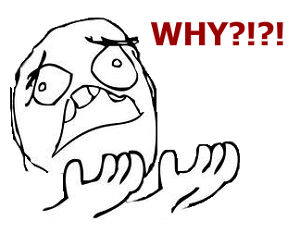